In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nltk
from langdetect import detect
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud as wc
import string
import re

from nltk import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Assuming your dataset is named 'df'
df = pd.read_csv('Nazario_5 + Nigerian_5 DATA SET FOR THESIS.csv')

In [ ]:
df.head()

,sender,receiver,date,subject,body,label,urls
0,"""Hu, Sylvia"" <Sylvia.Hu@ENRON.com>","""Acevedo, Felecia"" <Felecia.Acevedo@ENRON.com>...","Fri, 29 Jun 2001 08:36:09 -0500","FW: June 29 -- BNA, Inc. Daily Labor Report",User ID: enrondlr\nPW: bnaweb22\n-----Original...,0,"['http://web.bna.com', 'http://pubs.bna.com/ip..."
1,"""Webb, Jay"" <Jay.Webb@ENRON.com>","""Lambie, Chris"" <Chris.Lambie@ENRON.com>","Fri, 29 Jun 2001 09:37:04 -0500",NGX failover plan.,"Hi Chris, Tonight we are rolling out a new rep...",0,[]
2,"""Symms, Mark"" <Mark.Symms@ENRON.com>","""Thomas, Paul D."" <Paul.D.Thomas@ENRON.com>","Fri, 29 Jun 2001 08:39:30 -0500",RE: Intranet Site,Rika r these new?\n-----Original Message-----\...,0,['http://eastpower.dev.corp.enron.com/summary/...
3,"""Thorne, Judy"" <Judy.Thorne@ENRON.com>","""Grass, John"" <John.Grass@ENRON.com>, ""Nemec, ...","Fri, 29 Jun 2001 10:35:17 -0500",FW: ENA Upstream Company information,"John/Gerald,\nWe are currently trading under G...",0,[]
4,"""Williams, Jason R (Credit)"" <Jason.R.Williams...","""Nemec, Gerald"" <Gerald.Nemec@ENRON.com>, ""Dic...","Fri, 29 Jun 2001 10:40:02 -0500",New Master Physical,Gerald and Stacy -\nAttached is a worksheet fo...,0,[]


In [ ]:
columns_to_drop = ['sender', 'receiver','date']
df = df.drop(columns=columns_to_drop, axis=1)
df.head()

,subject,body,label,urls
0,"FW: June 29 -- BNA, Inc. Daily Labor Report",User ID: enrondlr\nPW: bnaweb22\n-----Original...,0,"['http://web.bna.com', 'http://pubs.bna.com/ip..."
1,NGX failover plan.,"Hi Chris, Tonight we are rolling out a new rep...",0,[]
2,RE: Intranet Site,Rika r these new?\n-----Original Message-----\...,0,['http://eastpower.dev.corp.enron.com/summary/...
3,FW: ENA Upstream Company information,"John/Gerald,\nWe are currently trading under G...",0,[]
4,New Master Physical,Gerald and Stacy -\nAttached is a worksheet fo...,0,[]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5714 entries, 0 to 5713
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  5713 non-null   object
 1   body     5701 non-null   object
 2   label    5714 non-null   int64 
 3   urls     5714 non-null   object
dtypes: int64(1), object(3)
memory usage: 178.7+ KB


In [ ]:
#Replacing '[]' with 0
df['urls'] = df['urls'].replace(['[]'], '0')

In [ ]:
#Function to check if a value is a URL
def is_url(value):
    if isinstance(value, str) and value.startswith('['):
        return 1
    else:
        return value

# Apply the function to the 'URL' column
df['urls'] = df['urls'].apply(is_url)

In [ ]:
df['urls'] = df['urls'].apply(pd.to_numeric)

In [ ]:
df.urls

0       1
1       0
2       1
3       0
4       0
       ..
5709    0
5710    1
5711    1
5712    1
5713    1
Name: urls, Length: 5714, dtype: int64

In [ ]:
df.isnull().sum()

subject     1
body       13
label       0
urls        0
dtype: int64

In [ ]:
df.describe()

,label,urls
count,5714.000000,5714.000000
mean,0.621106,0.518551
std,0.485154,0.499699
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

subject    0
body       0
label      0
urls       0
dtype: int64

In [ ]:
df['label'].value_counts()

label
1    3545
0    2155
Name: count, dtype: int64

In [ ]:
#combining subject and body in one column
df['combined_text'] = df['subject'].fillna('') + ' ' + df['body'].fillna('')
columns_to_drop = ['subject', 'body']
df = df.drop(columns=columns_to_drop, axis=1)
df.head()

,label,urls,combined_text
0,0,1,"FW: June 29 -- BNA, Inc. Daily Labor Report Us..."
1,0,0,"NGX failover plan. Hi Chris, Tonight we are ro..."
2,0,1,RE: Intranet Site Rika r these new?\n-----Orig...
3,0,0,FW: ENA Upstream Company information John/Gera...
4,0,0,New Master Physical Gerald and Stacy -\nAttach...


In [ ]:
# Text preprocessing: remove non-alphanumeric characters, convert to lowercase
df['combined_text'] = df['combined_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x.lower()))
df.head()

,label,urls,combined_text
0,0,1,fw june 29 bna inc daily labor report user id...
1,0,0,ngx failover plan hi chris tonight we are roll...
2,0,1,re intranet site rika r these new\noriginal me...
3,0,0,fw ena upstream company information johngerald...
4,0,0,new master physical gerald and stacy \nattache...


In [ ]:
#stemming, and removing stop words
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
df['combined_text'] = df['combined_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() if word not in stop_words]))
df.head()

,label,urls,combined_text
0,0,1,fw june 29 bna inc daili labor report user id ...
1,0,0,ngx failov plan hi chri tonight roll new repor...
2,0,1,intranet site rika r new origin messag thoma p...
3,0,0,fw ena upstream compani inform johngerald curr...
4,0,0,new master physic gerald staci attach workshee...


In [ ]:
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['combined_text'])
df.head()

,label,urls,combined_text
0,0,1,fw june 29 bna inc daili labor report user id ...
1,0,0,ngx failov plan hi chri tonight roll new repor...
2,0,1,intranet site rika r new origin messag thoma p...
3,0,0,fw ena upstream compani inform johngerald curr...
4,0,0,new master physic gerald staci attach workshee...


In [ ]:
import spacy

def identify_entities(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    # Replace or mask entities
    masked_text = text
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "DATE", "CARDINAL", "ORG", "GPE", "FAC", "MONEY", "QUANTITY"]:
            # Replace with a generic token or mask
            masked_text = masked_text.replace(ent.text, f"<{ent.label_}>")

    return masked_text



In [ ]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=b738bd7fac726fb6f6b5c94803af6dbe41efcf4da10eb82ed243754b87135e14
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
df['label'].value_counts()

label
1    3545
0    2155
Name: count, dtype: int64

In [ ]:
df.head()

,label,urls,combined_text
0,0,1,fw june 29 bna inc daili labor report user id ...
1,0,0,ngx failov plan hi chri tonight roll new repor...
2,0,1,intranet site rika r new origin messag thoma p...
3,0,0,fw ena upstream compani inform johngerald curr...
4,0,0,new master physic gerald staci attach workshee...


In [ ]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

# Choosing a model
model = MultinomialNB()

# Training the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9850877192982456
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       443
           1       0.98      0.99      0.99       697

    accuracy                           0.99      1140
   macro avg       0.99      0.98      0.98      1140
weighted avg       0.99      0.99      0.99      1140

Confusion Matrix:
 [[431  12]
 [  5 692]]


In [ ]:
from sklearn.model_selection import cross_val_score

# Assuming your model is named 'model'
cv_scores = cross_val_score(model, X_tfidf, df['label'], cv=10)  # 10-fold cross-validation

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))


Cross-Validation Scores: [0.96842105 0.96842105 0.97368421 0.98421053 0.99122807 0.95964912
 0.98421053 0.99122807 0.99473684 0.98596491]
Mean CV Score: 0.9801754385964913


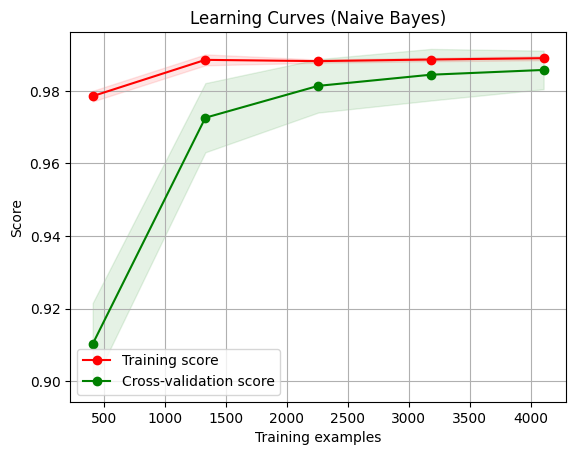

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Usage Example:
# Assuming you have X_train, y_train, and a model named model
title = "Learning Curves (Naive Bayes)"
cv = 10 # 10-fold cross-validation
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()


In [ ]:
import pickle
with open ('Multinomial_Naive_Bayes_classifier.pkl' , 'wb') as file:
  pickle.dump(model, file)

In [ ]:
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)